# Dino Bektesevic Exoplanets HW #1 
Jan 21, 2019

## Practice Plotting. 

Julia is excelent at plotting

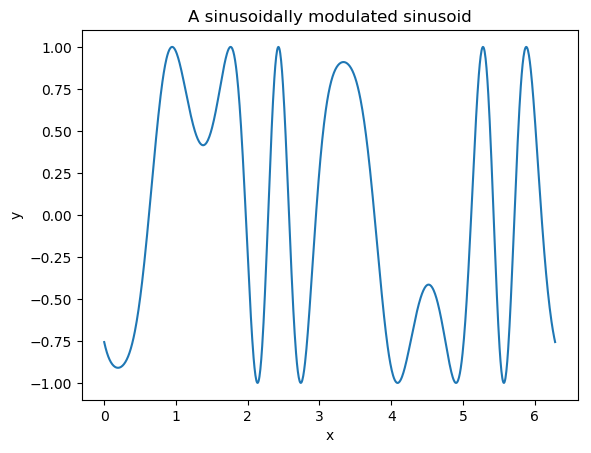

PyObject Text(24.0, 0.5, 'y')

In [2]:
using PyPlot;
x = range(0, stop=2*pi, length=1000); 
y = sin.(3*x + 4*cos.(2*x));
plot(x, y);
title("A sinusoidally modulated sinusoid")
xlabel("x") 
ylabel("y")

## Write a Newtons solver to Keplers Equation

Specifically it said to write a wrapper to Newthons root finding method to solve the Kepler equation so I understood it as "write a generic Newtons root finding method and use it to solve Keplers eq."

Starting off, we define the function that can take any function and its derivative and iterate as per Newtons prescription:

$$ x_{i+1} = x_i - \frac{f(x)}{\dot f(x)}$$

iteratively, until sufficiently converged $|x_{i+1}-x_i| < \epsilon$.

In [69]:
function newtonsMethod(f, fdot, starting_guess; precission=0.01)
    f_x = f(starting_guess)
    fdot_x = fdot(starting_guess)
    
    previous = starting_guess
    next = starting_guess - f_x/fdot_x
                
    while abs(next-previous) > precission
        previous = next
        next = previous - f(previous)/fdot(previous)
    end
    
    return next
end              

newtonsMethod (generic function with 1 method)

Following that, we write generic Keplers equation and its first derivation. We also write a function that returns optimal guess for the initial value so that one does not need to be supplied additionally. These functions, usually with parameters $E$, $M$ and $e$, are then used as partial functions in the wrapper such that they become only functions of $E$, since $M$ and $e$ are set by user.

In [404]:
function keplersEq(E, M, e)
    return E-e*sin(E)-M
end
    
function keplersEqDot(E, M, e)
    return 1-e*cos(E)
end
    
function guessE(M, e)
        return M+0.85*e*sign(sin(M))
end

function newtonKeplerSolver(M, e; precission=0.0001)
    E = guessE(M, e)
    f(E) = keplersEq(E, M, e)
    fdot(E) = keplersEqDot(E, M, e)
    return newtonsMethod(f, fdot, E, precission=precission)
end

newtonKeplerSolver (generic function with 1 method)

Lastly we'll write a pretty-print functionality because converting between degrees and rads gets booring quickly.

In [405]:
using Printf

function tabularInputsOutputs(E, M, e; units="rad")
    if units == "deg"
        Edeg, Mdeg = E, M #E%360, M%360
        Erad, Mrad = deg2rad(E), deg2rad(M) #deg2rad(E)%(2*pi), deg2rad(M)%(2*pi)
    end
    if units == "rad"
        Erad, Mrad = E, M #E%(2*pi), M%(2*pi)
        Edeg, Mdeg = rad2deg(E)%360, rad2deg(M)%360 #rad2deg(E)%360, rad2deg(M)%360
    end
    table = """
            Eccentric Anomaly     Mean Anomaly     eccentricity     
    (deg) $(@sprintf("%19.10f", Edeg)) $(@sprintf("%16.8f", Mdeg)) $(@sprintf("%16.10f", e))
    (rad) $(@sprintf("%19.10f", Erad)) $(@sprintf("%16.8f", Mrad)) $(@sprintf("%16.10f", e))
    """
    return table
end

function tabularInputsOutputs(E::Array, M::Array, e::Array; titles=nothing)
    
    table = tabularInputsOutputs(E[1], M[1], e[1])[1:65]
    if titles == nothing
        titles = repeat([" "], inner=(10, 1))
    end        
    for (EE, MM, ee, title) in zip(E, M, e, titles)
        tmpstr = tabularInputsOutputs(EE, MM, ee)
        table *= "\n"*title
        table *= tmpstr[65:length(tmpstr)]
    end
    return table
end

tabularInputsOutputs (generic function with 2 methods)

## Verify that the calculations are correct.

From WolframAlpha, for Earth:

 * mean anomaly $M=0.32$ radians
 * eccentricity $e=0.0167$
 
so expected value for the eccentric anomaly $E=0.3254$ radians.

In [406]:
M, e = 0.32, 0.0167
E = newtonKeplerSolver(M, e)

print(tabularInputsOutputs(E, M, e))

        Eccentric Anomaly     Mean Anomaly     eccentricity     
(deg)       18.6404829937      18.33464944     0.0167000000
(rad)        0.3253378024       0.32000000     0.0167000000


Lets run it for some other solar system objects.

In [408]:
M = [219.5, #mercury
    42.12, #venus
    66.8 #mars
]
e = [
    0.205630, #mercury
    0.006772, #venus
    0.0934 #mars    
]
M = map(deg2rad, M)
E = map(newtonKeplerSolver, M, e)

3-element Array{Float64,1}:
 3.718790042190138 
 0.7396974454206406
 1.254651125366292 

In [409]:
print(tabularInputsOutputs(E, M, e, titles=["Mercury", "Venus", "Mars"]))

        Eccentric Anomaly     Mean Anomaly     eccentricity     

Mercury
(deg)      213.0709743128     219.50000000     0.2056300000
(rad)        3.7187900422       3.83099771     0.2056300000

Venus
(deg)       42.3815417392      42.12000000     0.0067720000
(rad)        0.7396974454       0.73513268     0.0067720000

Mars
(deg)       71.8862142448      66.80000000     0.0934000000
(rad)        1.2546511254       1.16587994     0.0934000000
